In [3]:
import os
import glob
import matplotlib.pyplot as plt
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms
import torchvision.models as models


In [4]:
# GPU 설정 추가
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [5]:
def display_images(image_paths, title, max_images=4):
    plt.figure(figsize=(12, 3))
    for i, image_path in enumerate(image_paths[:max_images]):
        img = plt.imread(image_path)
        plt.subplot(1, max_images, i+1)
        plt.imshow(img)
        plt.axis('off')
        plt.title(title)
    plt.tight_layout()
    plt.show()
    


Train crack 이미지 개수: 17650


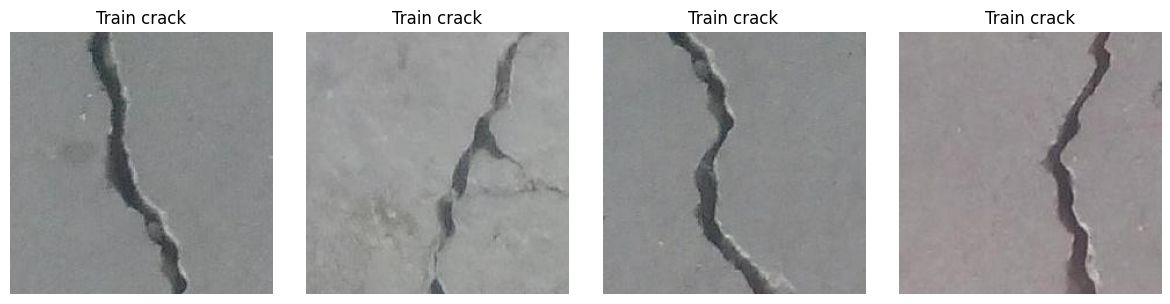

Train normal 이미지 개수: 17900


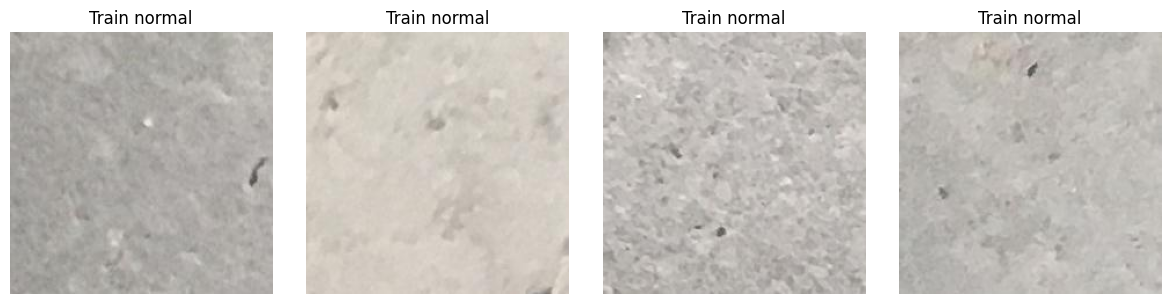

Val crack 이미지 개수: 1600


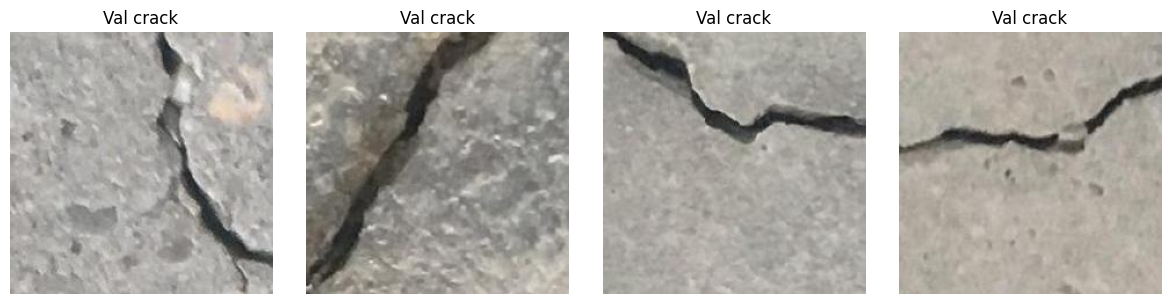

Val normal 이미지 개수: 1700


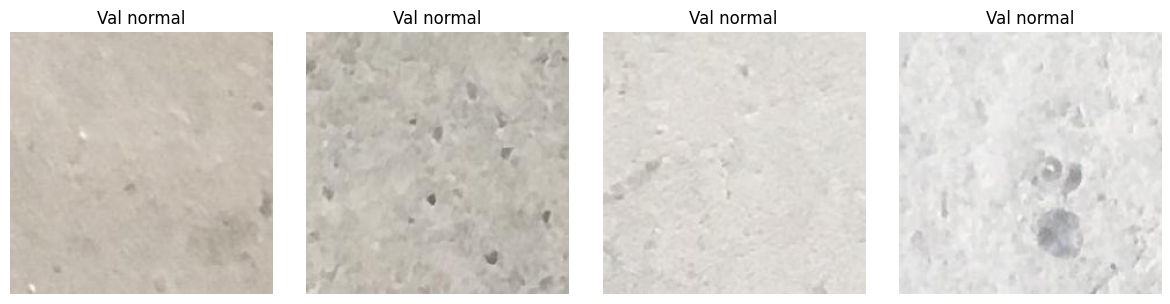

Test crack 이미지 개수: 100


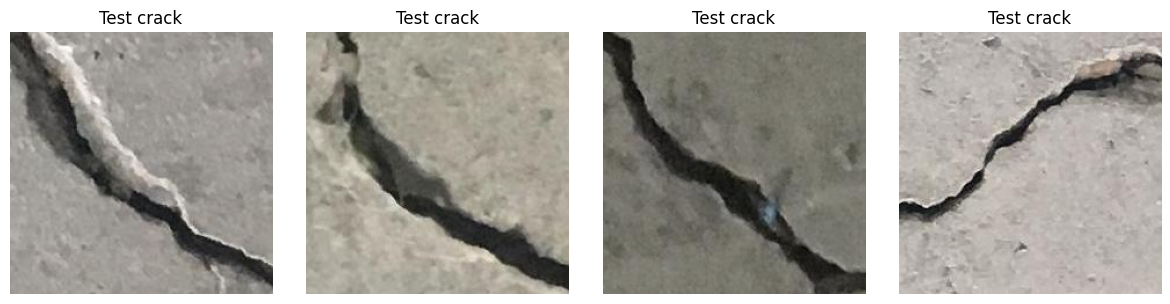

Test normal 이미지 개수: 100


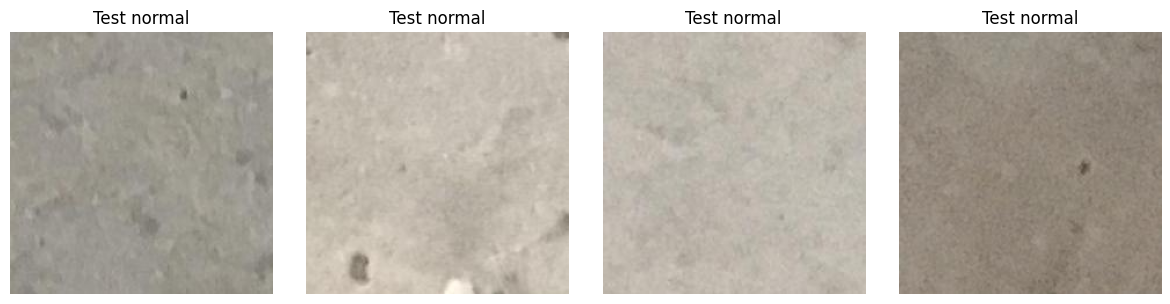

In [6]:
categories = ['Train crack', 'Train normal', 'Val crack', 'Val normal', 'Test crack', 'Test normal']

for category in categories:
    image_paths = glob.glob(f'../실습 파일/3/{category.lower().replace(" ","/")}/*')
    print(f'{category} 이미지 개수: {len(image_paths)}')
    display_images(image_paths, category)


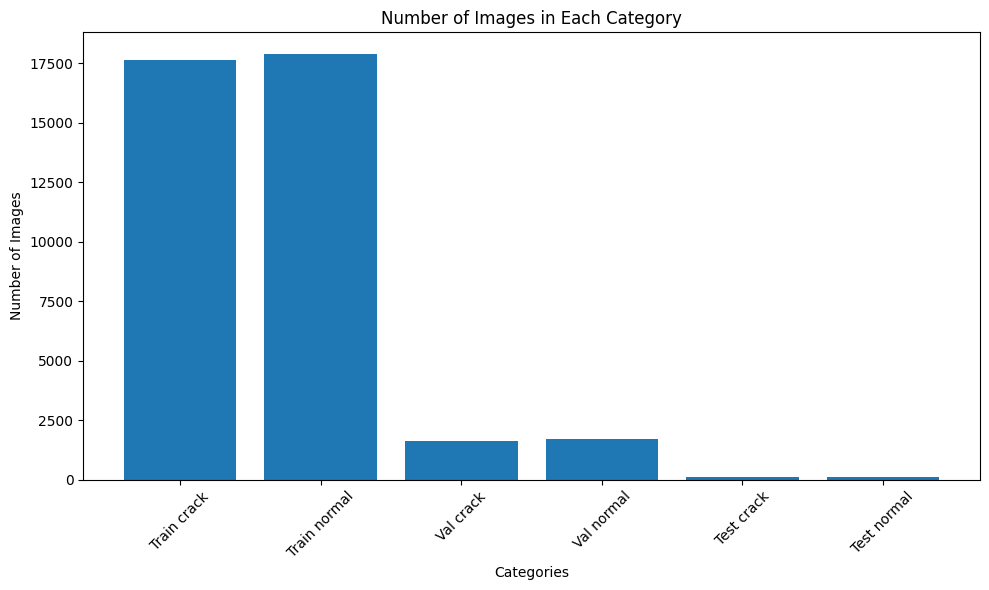

In [7]:
plt.figure(figsize=(10, 6))
plt.bar(categories, [len(glob.glob(f'../실습 파일/3/{category.lower().replace(" ","/")}/*')) for category in categories])
plt.xlabel('Categories')
plt.ylabel('Number of Images')
plt.title('Number of Images in Each Category')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()



In [8]:
transform = transforms.Compose([
    transforms.CenterCrop(224),
    transforms.RandomRotation(45),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])





In [9]:
train_dataset = ImageFolder(root='../실습 파일/3/train', transform=transform)
val_dataset = ImageFolder(root='../실습 파일/3/val', transform=transform)
test_dataset = ImageFolder(root='../실습 파일/3/test', transform=transform)

In [10]:
from torch.utils.data import SubsetRandomSampler
import numpy as np

num_of_train = len(train_dataset)
num_of_val = len(val_dataset)

train_indices = list(range(num_of_train))
val_indices = list(range(num_of_val))

np.random.shuffle(train_indices)
train_indices = train_indices[:int(num_of_train*0.8)]

np.random.shuffle(val_indices)
val_indices = val_indices[:int(num_of_val*0.2)]

train_sampler = SubsetRandomSampler(train_indices)
val_sampler = SubsetRandomSampler(val_indices)

# train_loader = DataLoader(train_dataset, batch_size=32, sampler=train_sampler)
# val_loader = DataLoader(val_dataset, batch_size=32, sampler=val_sampler)
# DataLoader 정의 시 pin_memory=True 추가 (데이터 전송 속도 향상)
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, pin_memory=True)

In [11]:
# net = models.vgg19(pretrained=True)
# net
# VGG19 모델 초기화 및 GPU로 이동
net = models.vgg19(pretrained=True)
net = net.to(device)  # GPU로 모델 이동

c:\Users\gfs12\anaconda3\envs\py310\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\gfs12\anaconda3\envs\py310\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [12]:
for param in net.parameters():
    param.requires_grad = False


In [13]:
net.classifier[6] = nn.Linear(4096, 2)
net.classifier[6].requires_grad = True
net.classifier[6] = net.classifier[6].to(device)  # 새로운 분류기 층도 GPU로 이동


In [14]:
criterion = nn.CrossEntropyLoss()
criterion = criterion.to(device)  # 손실 함수를 GPU로 이동


In [15]:
def train_model(optimizer_name, net, train_loader, val_loader, criterion, num_epochs=20):
    if optimizer_name == 'SGD':
        optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
    elif optimizer_name == 'Adam':
        optimizer = optim.Adam(net.parameters(), lr=0.0001)
    elif optimizer_name == 'RAdam':
        optimizer = optim.RAdam(net.parameters(), lr=0.0001)
    elif optimizer_name == 'AdamW':
        optimizer = optim.AdamW(net.parameters(), lr=0.0001)
    else:
        raise ValueError(f"Invalid optimizer: {optimizer_name}")
    
    # 학습/검증 손실과 정확도 기록
    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []
    
    for epoch in range(num_epochs):
        net.train()
        running_loss = 0.0
        correct = 0
        total = 0
        
        for inputs, labels in train_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            optimizer.zero_grad()
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            # 정확도 계산
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            running_loss += loss.item()
        
        # 에포크당 평균 손실과 정확도 계산
        epoch_loss = running_loss / len(train_loader)
        epoch_acc = 100 * correct / total
        
        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_acc)
        
        # 검증
        net.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0
        
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                outputs = net(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                
                _, predicted = torch.max(outputs.data, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()
        
        # 검증 손실과 정확도 계산
        epoch_val_loss = val_loss / len(val_loader)
        epoch_val_acc = 100 * val_correct / val_total
        
        val_losses.append(epoch_val_loss)
        val_accuracies.append(epoch_val_acc)
        
        print(f"Epoch {epoch+1}/{num_epochs}, "
              f"Train Loss: {epoch_loss:.4f}, "
              f"Train Accuracy: {epoch_acc:.2f}%, "
              f"Val Loss: {epoch_val_loss:.4f}, "
              f"Val Accuracy: {epoch_val_acc:.2f}%")
    
    return train_losses, train_accuracies, val_losses, val_accuracies

In [16]:
train_losses_SGD, train_accuracies_SGD, val_losses_SGD, val_accuracies_SGD = train_model('SGD', net, train_loader, val_loader, criterion)


Epoch 1/20, Train Loss: 0.2002, Train Accuracy: 92.06%, Val Loss: 0.0864, Val Accuracy: 97.27%
Epoch 2/20, Train Loss: 0.1575, Train Accuracy: 94.03%, Val Loss: 0.0745, Val Accuracy: 97.67%
Epoch 3/20, Train Loss: 0.1515, Train Accuracy: 94.18%, Val Loss: 0.0661, Val Accuracy: 98.03%
Epoch 4/20, Train Loss: 0.1480, Train Accuracy: 94.37%, Val Loss: 0.0634, Val Accuracy: 98.06%
Epoch 5/20, Train Loss: 0.1426, Train Accuracy: 94.47%, Val Loss: 0.0618, Val Accuracy: 98.03%
Epoch 6/20, Train Loss: 0.1418, Train Accuracy: 94.60%, Val Loss: 0.0929, Val Accuracy: 96.30%
Epoch 7/20, Train Loss: 0.1419, Train Accuracy: 94.59%, Val Loss: 0.0606, Val Accuracy: 98.12%
Epoch 8/20, Train Loss: 0.1447, Train Accuracy: 94.49%, Val Loss: 0.0682, Val Accuracy: 97.42%
Epoch 9/20, Train Loss: 0.1404, Train Accuracy: 94.67%, Val Loss: 0.0753, Val Accuracy: 97.33%
Epoch 10/20, Train Loss: 0.1347, Train Accuracy: 94.85%, Val Loss: 0.0560, Val Accuracy: 98.27%
Epoch 11/20, Train Loss: 0.1378, Train Accuracy: 

In [17]:
# 초기화

net = models.vgg19(pretrained=True)
net = net.to(device)  # GPU로 이동


for param in net.parameters():
    param.requires_grad = False

net.classifier[6] = nn.Linear(4096, 2)
net.classifier[6].requires_grad = True
net.classifier[6] = net.classifier[6].to(device)  # 새로운 분류기 층도 GPU로 이동


In [18]:
train_losses_Adam, train_accuracies_Adam, val_losses_Adam, val_accuracies_Adam = train_model('Adam', net, train_loader, val_loader, criterion)

Epoch 1/20, Train Loss: 0.2777, Train Accuracy: 89.83%, Val Loss: 0.1472, Val Accuracy: 96.33%
Epoch 2/20, Train Loss: 0.1645, Train Accuracy: 94.30%, Val Loss: 0.1134, Val Accuracy: 96.91%
Epoch 3/20, Train Loss: 0.1434, Train Accuracy: 94.79%, Val Loss: 0.0920, Val Accuracy: 97.48%
Epoch 4/20, Train Loss: 0.1343, Train Accuracy: 95.06%, Val Loss: 0.0943, Val Accuracy: 96.85%
Epoch 5/20, Train Loss: 0.1318, Train Accuracy: 95.13%, Val Loss: 0.0852, Val Accuracy: 97.30%
Epoch 6/20, Train Loss: 0.1293, Train Accuracy: 95.34%, Val Loss: 0.0910, Val Accuracy: 96.85%
Epoch 7/20, Train Loss: 0.1214, Train Accuracy: 95.60%, Val Loss: 0.0835, Val Accuracy: 97.06%
Epoch 8/20, Train Loss: 0.1269, Train Accuracy: 95.26%, Val Loss: 0.0744, Val Accuracy: 97.52%
Epoch 9/20, Train Loss: 0.1226, Train Accuracy: 95.49%, Val Loss: 0.0745, Val Accuracy: 97.58%
Epoch 10/20, Train Loss: 0.1207, Train Accuracy: 95.56%, Val Loss: 0.0741, Val Accuracy: 97.58%
Epoch 11/20, Train Loss: 0.1211, Train Accuracy: 

In [19]:
# 초기화

net = models.vgg19(pretrained=True)
net = net.to(device)  # GPU로 이동


for param in net.parameters():
    param.requires_grad = False

net.classifier[6] = nn.Linear(4096, 2)
net.classifier[6].requires_grad = True
net.classifier[6] = net.classifier[6].to(device)  # 새로운 분류기 층도 GPU로 이동


In [20]:
train_losses_AdamW, train_accuracies_AdamW, val_losses_AdamW, val_accuracies_AdamW = train_model('AdamW', net, train_loader, val_loader, criterion)


Epoch 1/20, Train Loss: 0.2806, Train Accuracy: 89.83%, Val Loss: 0.1453, Val Accuracy: 96.30%
Epoch 2/20, Train Loss: 0.1657, Train Accuracy: 94.08%, Val Loss: 0.1092, Val Accuracy: 96.88%
Epoch 3/20, Train Loss: 0.1493, Train Accuracy: 94.67%, Val Loss: 0.0913, Val Accuracy: 97.27%
Epoch 4/20, Train Loss: 0.1404, Train Accuracy: 94.89%, Val Loss: 0.0927, Val Accuracy: 96.97%
Epoch 5/20, Train Loss: 0.1325, Train Accuracy: 95.01%, Val Loss: 0.0777, Val Accuracy: 97.79%
Epoch 6/20, Train Loss: 0.1298, Train Accuracy: 95.16%, Val Loss: 0.0842, Val Accuracy: 97.36%
Epoch 7/20, Train Loss: 0.1238, Train Accuracy: 95.39%, Val Loss: 0.0821, Val Accuracy: 97.21%
Epoch 8/20, Train Loss: 0.1269, Train Accuracy: 95.36%, Val Loss: 0.0743, Val Accuracy: 97.70%
Epoch 9/20, Train Loss: 0.1259, Train Accuracy: 95.21%, Val Loss: 0.0712, Val Accuracy: 98.00%
Epoch 10/20, Train Loss: 0.1186, Train Accuracy: 95.64%, Val Loss: 0.0796, Val Accuracy: 97.24%
Epoch 11/20, Train Loss: 0.1188, Train Accuracy: 

In [21]:
# 초기화

net = models.vgg19(pretrained=True)
net = net.to(device)  # GPU로 이동


for param in net.parameters():
    param.requires_grad = False

net.classifier[6] = nn.Linear(4096, 2)
net.classifier[6].requires_grad = True
net.classifier[6] = net.classifier[6].to(device)  # 새로운 분류기 층도 GPU로 이동


In [22]:
train_losses_RAdam, train_accuracies_RAdam, val_losses_RAdam, val_accuracies_RAdam = train_model('RAdam', net, train_loader, val_loader, criterion)


Epoch 1/20, Train Loss: 0.4132, Train Accuracy: 82.59%, Val Loss: 0.2174, Val Accuracy: 94.91%
Epoch 2/20, Train Loss: 0.1998, Train Accuracy: 93.23%, Val Loss: 0.1321, Val Accuracy: 96.55%
Epoch 3/20, Train Loss: 0.1620, Train Accuracy: 94.21%, Val Loss: 0.1093, Val Accuracy: 96.91%
Epoch 4/20, Train Loss: 0.1454, Train Accuracy: 94.71%, Val Loss: 0.0979, Val Accuracy: 96.91%
Epoch 5/20, Train Loss: 0.1379, Train Accuracy: 94.94%, Val Loss: 0.0891, Val Accuracy: 97.12%
Epoch 6/20, Train Loss: 0.1313, Train Accuracy: 95.12%, Val Loss: 0.0836, Val Accuracy: 97.30%
Epoch 7/20, Train Loss: 0.1268, Train Accuracy: 95.44%, Val Loss: 0.0762, Val Accuracy: 97.79%
Epoch 8/20, Train Loss: 0.1268, Train Accuracy: 95.19%, Val Loss: 0.0851, Val Accuracy: 96.97%
Epoch 9/20, Train Loss: 0.1224, Train Accuracy: 95.46%, Val Loss: 0.0809, Val Accuracy: 97.21%
Epoch 10/20, Train Loss: 0.1238, Train Accuracy: 95.38%, Val Loss: 0.0886, Val Accuracy: 96.67%
Epoch 11/20, Train Loss: 0.1174, Train Accuracy: 

In [23]:
# 초기화

net = models.vgg19(pretrained=True)
net = net.to(device)  # GPU로 이동


for param in net.parameters():
    param.requires_grad = False

net.classifier[6] = nn.Linear(4096, 2)
net.classifier[6].requires_grad = True
net.classifier[6] = net.classifier[6].to(device)  # 새로운 분류기 층도 GPU로 이동


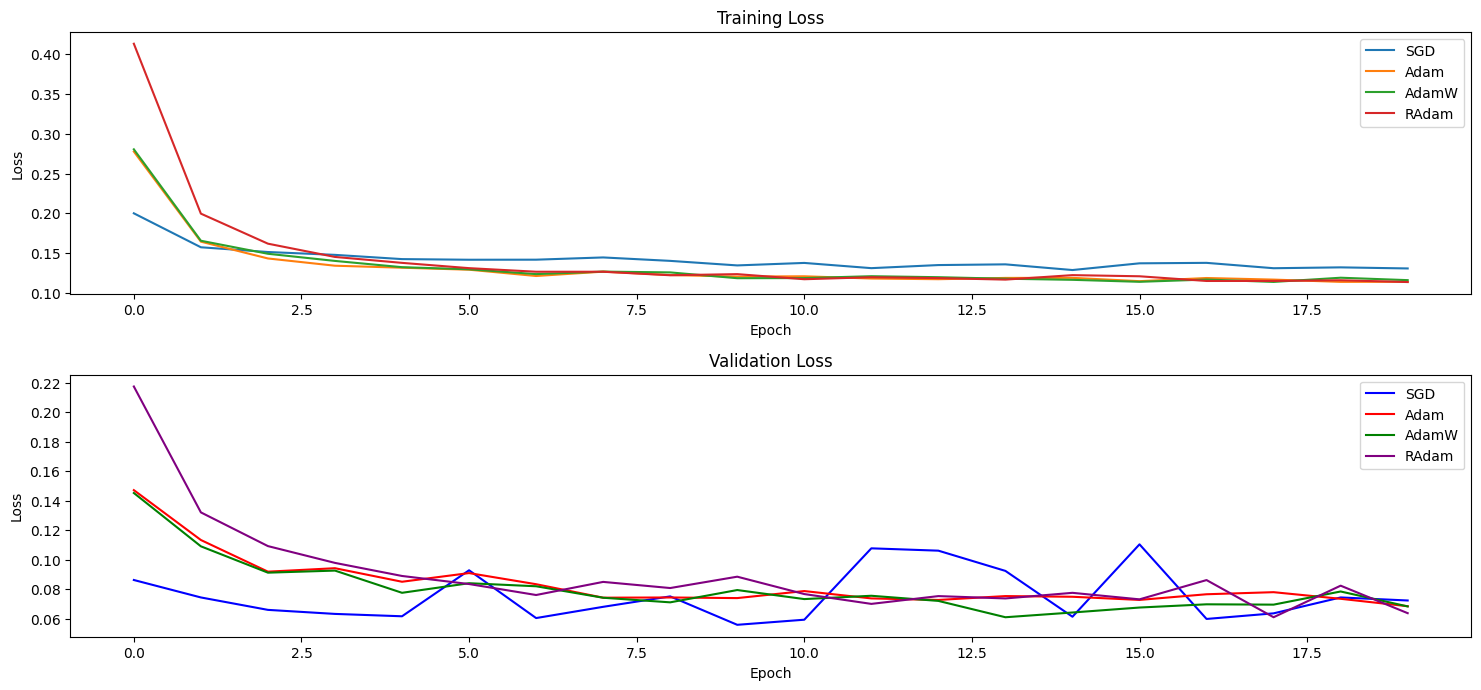

In [24]:
# 학습 손실과 검증 정확도 그래프

plt.figure(figsize=(15, 10))

# 학습 손실 그래프
plt.subplot(3, 1, 1)
plt.plot(train_losses_SGD, label='SGD')
plt.plot(train_losses_Adam, label='Adam')
plt.plot(train_losses_AdamW, label='AdamW')
plt.plot(train_losses_RAdam, label='RAdam')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()

# 검증 손실 그래프
plt.subplot(3, 1, 2)
plt.plot(val_losses_SGD, label='SGD', color='blue')
plt.plot(val_losses_Adam, label='Adam', color='red')
plt.plot(val_losses_AdamW, label='AdamW', color='green')
plt.plot(val_losses_RAdam, label='RAdam', color='purple')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Validation Loss')
plt.legend()

plt.tight_layout()
plt.show()








In [25]:
# Image load 및 tensor 변환
def load_and_transform_image(image_path, transform):
    image = Image.open(image_path)
    image = transform(image).unsqueeze(0)
    return image.to(device)  # GPU로 이동

In [26]:
class_folders = {
    'crack': '../실습 파일/3/test/crack',
    'normal': '../실습 파일/3/test/normal'
}




In [27]:
def denormalize(tensor):
    # ImageNet 정규화에 사용된 평균과 표준편차
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
    
    # 정규화 역변환
    return tensor * std + mean


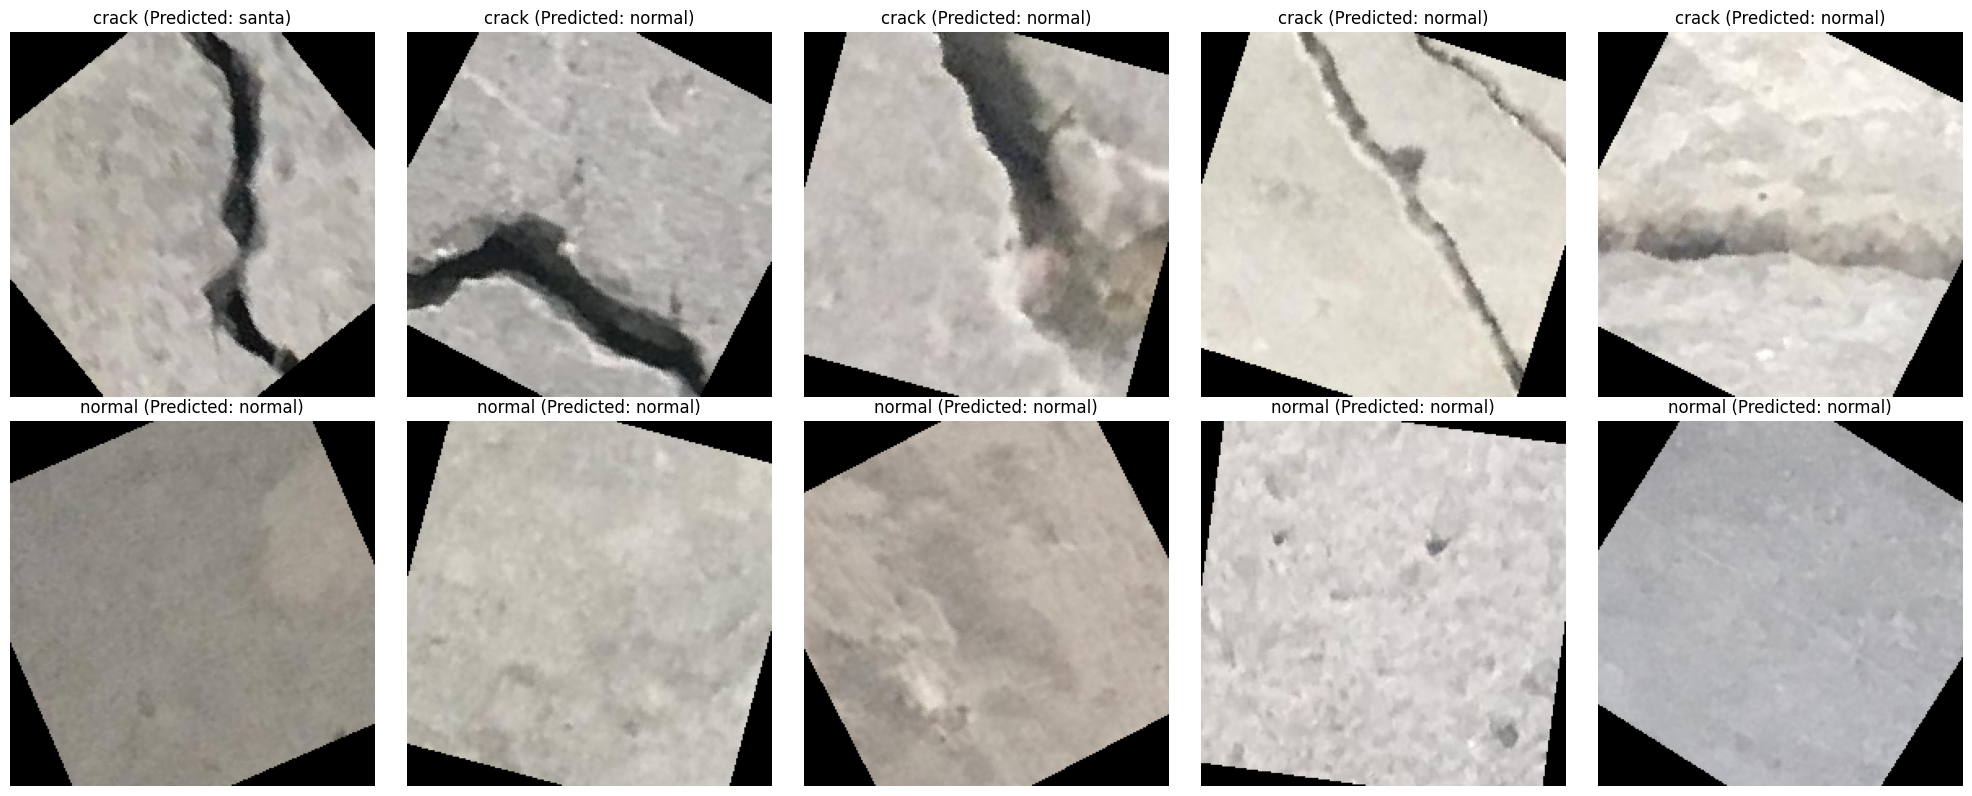

In [28]:
plt.figure(figsize=(20, 8))

counter = 1


for class_name, folder_path in class_folders.items():
    image_paths = glob.glob(os.path.join(folder_path, '*'))
    selected_paths = np.random.choice(image_paths, size=5, replace=False)
    
    for image_path in selected_paths:
        image = load_and_transform_image(image_path, transform)
        
        net.eval()
        
        with torch.no_grad():
            outputs = net(image)
            _, predicted = torch.max(outputs, 1)
        prediction = 'santa' if predicted.item() == 1 else 'normal'
        
        plt.subplot(2, 5, counter)
        # denormalize 함수를 사용하여 이미지 복원
        display_image = denormalize(image.cpu().squeeze())
        plt.imshow(display_image.permute(1, 2, 0).clamp(0, 1))  # 값을 0~1 범위로 제한
        plt.title(f'{class_name} (Predicted: {prediction})')
        plt.axis('off')
        counter += 1

plt.tight_layout()
plt.show()